# Image processing with Python

- This is a tutorial on the basics of image analysis with Python

## 1. Importing Modules & Packages

- Import the necesary packages

In [1]:
# import neccesary libraries for basic image analysis
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import skimage.io as skio

## 2. Loading Image Data and vizualize

*   Load all images in the /data folder (not one by one, but efficiently using a loop or list comprehension).
*   Visualize the images using subplots, arranging them in 5 rows and 2 columns (left column for noisy images and right column for the corresponding ground truth (GT) images).
*   Ensure the color bar range is the same for both columns, i.e., use the same color scale for all images.

In [29]:
data_folder = "data"
imagenes = []
for i in os.listdir(data_folder):
    if i.endswith(".jpg") or i.endswith(".tif"):
        imagenes.append(os.path.join(data_folder, i))

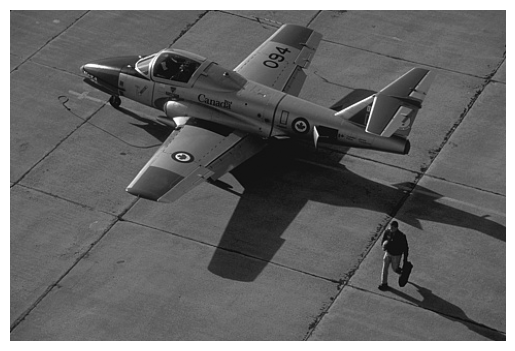

In [30]:
# mostrar item 3 de imagenes 
img_path = imagenes[3]
img = skio.imread(img_path)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

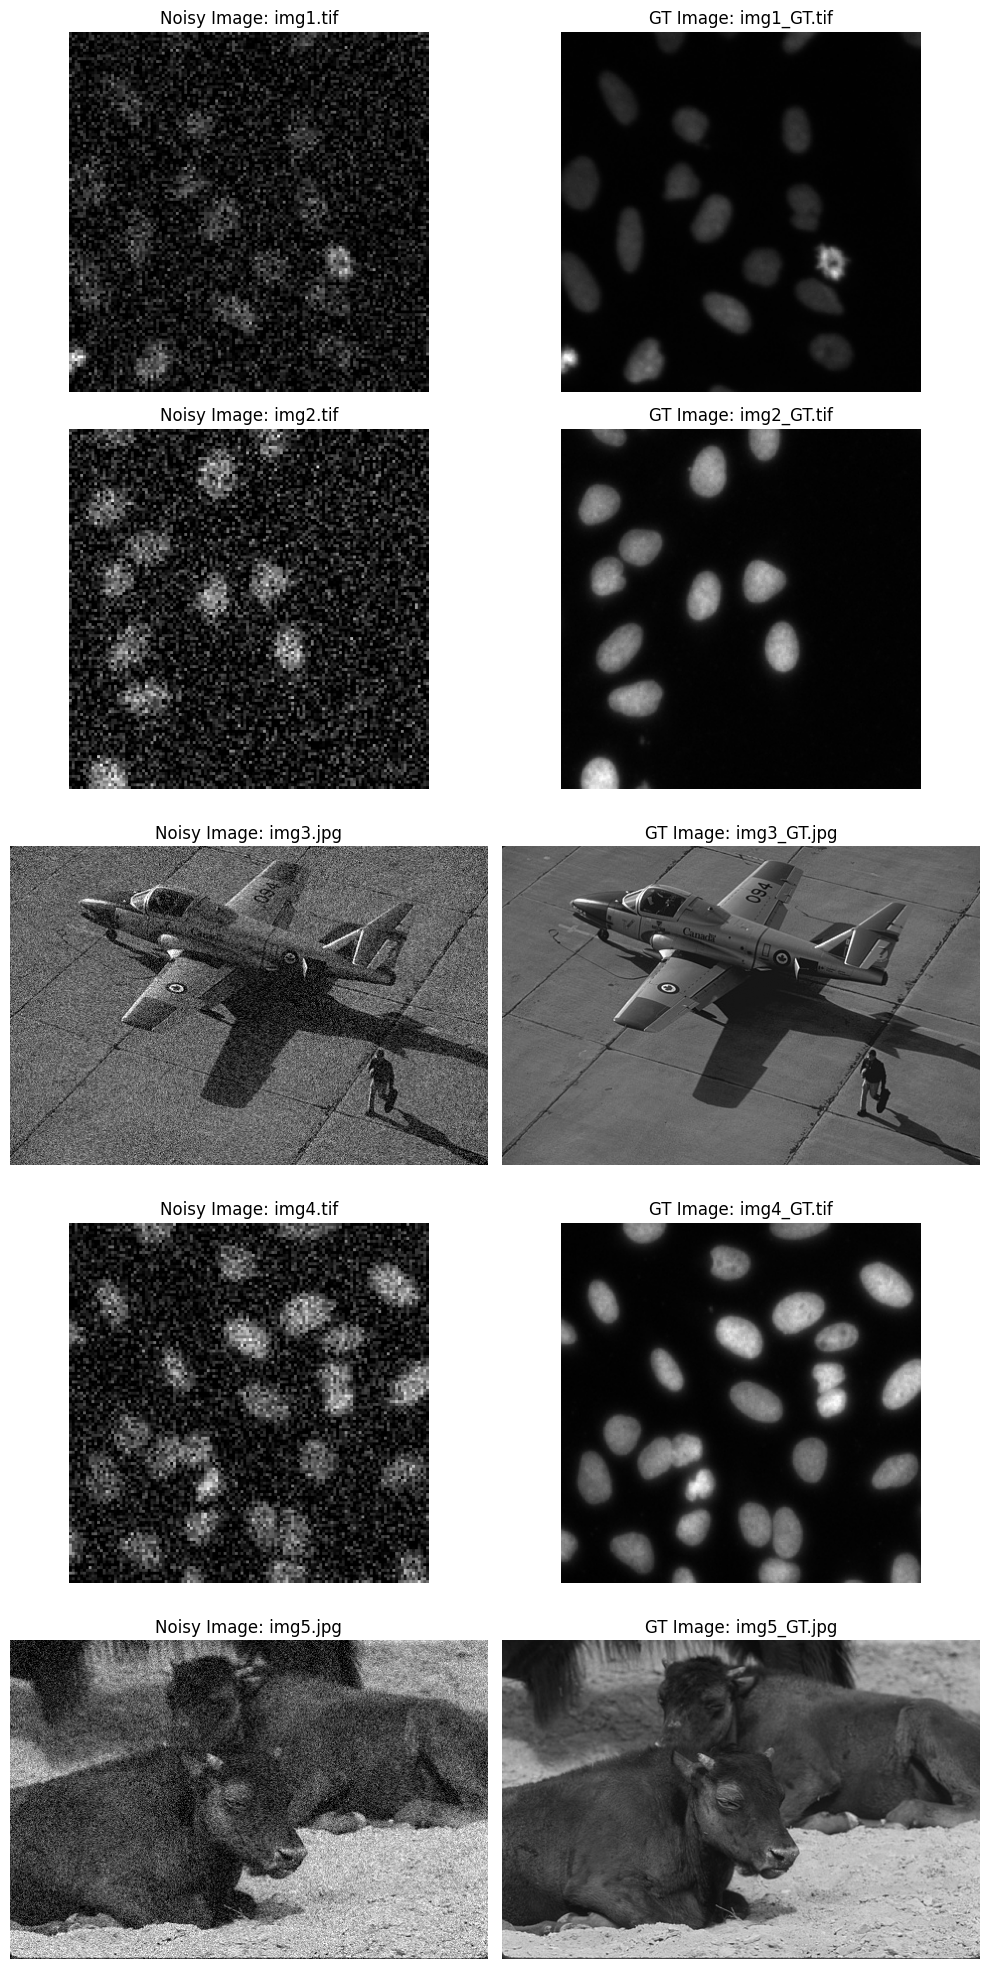

In [2]:
# Load all images in the /data folder, using a loop or list comprehension
data_folder = 'data'
image_files = [f for f in os.listdir(data_folder) if f.endswith('.jpg') or f.endswith('.tif')]

# Separate noisy and GT images
noisy_images = []
gt_images = []
noisy_names = []
gt_names = []

for image_file in sorted(image_files):
    img = skio.imread(os.path.join(data_folder, image_file))
    if '_GT' in image_file:
        gt_images.append(img)
        gt_names.append(image_file)
    else:
        noisy_images.append(img)
        noisy_names.append(image_file)

num_images = len(noisy_images)

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 4*5))

for i in range(num_images):
    axes[i, 0].imshow(noisy_images[i], cmap='gray', vmin=0, vmax=255)
    axes[i, 0].set_title(f'Noisy Image: {noisy_names[i]}')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(gt_images[i], cmap='gray', vmin=0, vmax=255)
    axes[i, 1].set_title(f'GT Image: {gt_names[i]}')
    axes[i, 1].axis('off')

# color bar
plt.tight_layout()
plt.show()


## 3. Spatial filtering

### Low pass Filtering

*   Select  two low-pass filters of your choice.
*   Use widgets for the interactive selection of the parameters and select the best values for img4 and img5 (independently). In other words, find the parameters that blur out the noise while keeping the structures of interest.
*  Calulate the RMSE and SSIM (Structural Similarity Index Measure) between the noisy image and the reulst of teh filtering with respect to the GT.
*   Visualize the best results using subplots. For each image, display:
    - The noisy image.
    - The corresponding ground truth (GT).
    - The results of the two filtering methods.
*   Ensure the color bar range is the same for both columns, i.e., use the same color scale for all images.
*   Print the values of RMSE and SSIM on teh corresponding images.   

In [ ]:
from skimage.metrics import structural_similarity as ssim, mean_squared_error
from skimage import filters
import ipywidgets as widgets
from ipywidgets import interact

# The metrics function is designed to evaluate the similarity between two images: a filtered image (filtered) and a ground truth image (gt).
# First, both input images are converted to 32-bit floating point arrays to ensure consistent numerical precision during calculations. 
# The RMSE is calculated by first determining the mean squared error (MSE) between the two images using the mean_squared_error function, 
# and then taking the square root of this value. 
# RMSE provides a measure of the average magnitude of the differences between corresponding pixel values in the two images, 
# with lower values indicating greater similarity.
# 
# Next, the function computes the SSIM, which is a perceptual metric that considers image degradation as perceived changes 
# in structural information, luminance, and contrast. 
# The data_range parameter for SSIM is set to the difference between the maximum and minimum values in the ground truth image (gt). 
# 
# If the image is constant (i.e., gt.max() == gt.min()), the data range is set to 1.0 to avoid division by zero.
# Finally, the function returns both the RMSE and SSIM values as a tuple, 
# providing a quantitative assessment of how closely the filtered image matches the ground truth. 
def metrics(filtered, gt):
    filtered = filtered.astype(np.float32)
    gt = gt.astype(np.float32)
    rmse = np.sqrt(mean_squared_error(gt, filtered))
    dr = float(gt.max() - gt.min()) if gt.max() != gt.min() else 1.0
    ssim_val = ssim(gt, filtered, data_range=dr)
    return rmse, ssim_val

def apply_filters(noisy, gt, sigma, ksize_median):
    gauss = filters.gaussian(noisy, sigma=sigma, preserve_range=True)

    k = int(ksize_median)
    if noisy.dtype != np.uint8:
        median = cv2.medianBlur(np.clip(noisy, 0, 255).astype(np.uint8), k).astype(np.float32)
    else:
        median = cv2.medianBlur(noisy, k).astype(np.float32)

    # Ensure same dtype for metrics
    gauss_f = gauss.astype(np.float32)
    gt_f    = gt.astype(np.float32)

    # Metrics vs GT
    rmse_g, ssim_g = metrics(gauss_f, gt_f)
    rmse_m, ssim_m = metrics(median, gt_f)

    # Same color scale for all panels
    #vmin = float(min(noisy.min(), gt.min(), gauss_f.min(), median.min()))
    #vmax = float(max(noisy.max(), gt.max(), gauss_f.max(), median.max()))

    # Plot
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    im0 = axes[0].imshow(noisy, cmap='gray', vmin=0, vmax=255)
    axes[0].set_title("Noisy"); axes[0].axis('off')

    axes[1].imshow(gt, cmap='gray', vmin=0, vmax=255)
    axes[1].set_title("Ground Truth"); axes[1].axis('off')

    axes[2].imshow(gauss, cmap='gray', vmin=0, vmax=255)
    axes[2].set_title(f"Gaussian (σ={sigma:.3f})\nRMSE={rmse_g:.3f}, SSIM={ssim_g:.4f}")
    axes[2].axis('off')

    axes[3].imshow(median, cmap='gray', vmin=0, vmax=255)
    axes[3].set_title(f"Median (k={k})\nRMSE={rmse_m:.3f}, SSIM={ssim_m:.4f}")
    axes[3].axis('off')

    # One shared colorbar (same scale for all images)
    #fig.colorbar(im0, ax=axes, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

img4_noisy = noisy_images[3]
img4_gt    = gt_images[3]

img5_noisy = noisy_images[4]
img5_gt    = gt_images[4]

# For both img4 and img5, 
# This decorator automatically generates sliders for the function's parameters: 
# sigma (the standard deviation for the Gaussian filter) 
# and ksize_median (the kernel size for the median filter). 
# The ranges for these sliders are specified: sigma varies from 0.5 to 10.0 in steps of 0.5, 
# and ksize_median varies from 3 to 15 in steps of 2.

print("Adjust parameters for img4:")
@interact(sigma=(0.05, 10.0, 0.5), ksize_median=(3, 15, 2))
def _w_img4(sigma=2.0, ksize_median=3):
    apply_filters(img4_noisy, img4_gt, sigma=sigma, ksize_median=ksize_median)

print("Adjust parameters for img5:")
@interact(sigma=(0.05, 10.0, 0.5), ksize_median=(3, 15, 2))
def _w_img5(sigma=2.0, ksize_median=3):
    apply_filters(img5_noisy, img5_gt, sigma=sigma, ksize_median=ksize_median)


Adjust parameters for img4:


interactive(children=(FloatSlider(value=2.0, description='sigma', max=10.0, min=0.05, step=0.5), IntSlider(val…

Adjust parameters for img5:


interactive(children=(FloatSlider(value=2.0, description='sigma', max=10.0, min=0.05, step=0.5), IntSlider(val…

* El ssim mide cuánto se mantienen las estructuras de las imágenes. Si hay correspondencia entre lo testeado y lo real, da un valor alto. Si no la hay, da un valo bajo. Normalizado entre 0 y 1.

* El MSE da cuánto cambian los píxeles entre las dos imágenes (lo testeado y lo real). Menor es mejor.

### High pass Filtering

*   Select two high-pass filters of your choice.
*   Use widgets for the interactive selection of the parameters and choose the best values for img1 and img3 (independently). In other words, find the parameters that remove low-frequency noise while preserving the high-frequency structures of interest.
*   Visualize the results using subplots. For each image, display:
    - The noisy image.
    - The results of the two filtering methods.
*   Repeat the procesing for img1_GT and img3_GT. For img1_GT, first invert the image, i.e using the operaton img = 255 - img.
*   Calulate the Peak-Signal-To-Noise-Ratio (PSNR) for all images and print them over them in the plot

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact
from skimage.metrics import peak_signal_noise_ratio as psnr

def psnr_vs(gt, img):
    gt = gt.astype(np.float32)
    img = img.astype(np.float32)
    dr = float(gt.max() - gt.min()) if gt.max() != gt.min() else 1.0
    return psnr(gt, img, data_range=dr)

def apply_filters(noisy, ref, ksize_lap=3, D0=40):
    # --- Laplacian (high-pass) ---
    f = noisy.astype(np.float32)
    k = int(ksize_lap)
    if k < 1: k = 1
    if k % 2 == 0: k += 1  # must be odd
    lap = cv2.Laplacian(f, ddepth=cv2.CV_32F, ksize=k)
    imagen_laplaciana = np.clip(np.abs(lap), 0, 255)

    # --- Ideal high-pass in frequency domain ---
    F = np.fft.fft2(f)
    F_shifted = np.fft.fftshift(F)
    M, N = f.shape
    cy, cx = M // 2, N // 2
    y, x = np.ogrid[:M, :N]
    D = np.sqrt((y - cy)**2 + (x - cx)**2)
    H_pasa_alto = np.ones((M, N), dtype=np.float32)
    H_pasa_alto[D <= float(D0)] = 0.0
    F_filtrado_pasa_alto = F_shifted * H_pasa_alto
    F_ishifted_pasa_alto = np.fft.ifftshift(F_filtrado_pasa_alto)
    imagen_pasa_alto = np.abs(np.fft.ifft2(F_ishifted_pasa_alto))
    imagen_pasa_alto = np.clip(imagen_pasa_alto, 0, 255)

    # --- PSNR vs reference (GT) ---
    p_in  = psnr_vs(ref, noisy)
    p_lap = psnr_vs(ref, imagen_laplaciana)
    p_fft = psnr_vs(ref, imagen_pasa_alto)

    # --- Plot: Input | Laplacian | FFT HP ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(noisy, cmap='gray', vmin=0, vmax=255)
    axes[0].set_title(f"Input\nPSNR={p_in:.2f} dB"); axes[0].axis('off')

    axes[1].imshow(imagen_laplaciana, cmap='gray', vmin=0, vmax=255)
    axes[1].set_title(f"Filtrado Laplaciano (ksize={k})\nPSNR={p_lap:.2f} dB"); axes[1].axis('off')

    axes[2].imshow(imagen_pasa_alto, cmap='gray', vmin=0, vmax=255)
    axes[2].set_title(f"Filtrado Pasa Alto (D0={int(D0)})\nPSNR={p_fft:.2f} dB"); axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# --- images you already have ---
img1_noisy = noisy_images[0]
img1_gt    = gt_images[0]
img3_noisy = noisy_images[2]
img3_gt    = gt_images[2]

# Reasonable ranges
max_d0_img1 = int(min(img1_noisy.shape) // 2)
max_d0_img3 = int(min(img3_noisy.shape) // 2)

print("Tune on img1 (noisy) vs img1_GT:")
@interact(ksize_lap=(1, 11, 2), D0=(1, max_d0_img1, 1))
def _w_img1_noisy(ksize_lap=3, D0=40):
    apply_filters(img1_noisy, ref=img1_gt, ksize_lap=ksize_lap, D0=D0)

print("Tune on img3 (noisy) vs img3_GT:")
@interact(ksize_lap=(1, 11, 2), D0=(1, max_d0_img3, 1))
def _w_img3_noisy(ksize_lap=3, D0=40):
    apply_filters(img3_noisy, ref=img3_gt, ksize_lap=ksize_lap, D0=D0)

# --- Repeat the processing for GT ---
# For img1_GT, invert first: img = 255 - img
print("Process img1_GT (invert input), PSNR vs original GT:")
@interact(ksize_lap=(1, 11, 2), D0=(1, max_d0_img1, 1))
def _w_img1_gt(ksize_lap=3, D0=40):
    inp = 255 - img1_gt
    apply_filters(inp, ref=img1_gt, ksize_lap=ksize_lap, D0=D0)

print("Process img3_GT (no inversion), PSNR vs original GT:")
@interact(ksize_lap=(1, 11, 2), D0=(1, max_d0_img3, 1))
def _w_img3_gt(ksize_lap=3, D0=40):
    apply_filters(img3_gt, ref=img3_gt, ksize_lap=ksize_lap, D0=D0)


Tune on img1 (noisy) vs img1_GT:


interactive(children=(IntSlider(value=3, description='ksize_lap', max=11, min=1, step=2), IntSlider(value=40, …

Tune on img3 (noisy) vs img3_GT:


interactive(children=(IntSlider(value=3, description='ksize_lap', max=11, min=1, step=2), IntSlider(value=40, …

Process img1_GT (invert input), PSNR vs original GT:


interactive(children=(IntSlider(value=3, description='ksize_lap', max=11, min=1, step=2), IntSlider(value=40, …

Process img3_GT (no inversion), PSNR vs original GT:


interactive(children=(IntSlider(value=3, description='ksize_lap', max=11, min=1, step=2), IntSlider(value=40, …

## 4. Border detection
*   Apply Sobel, Prewitt y Canny methods for edge detection to the images
*   Use widgets for the interactive selection of the parameters and choose the best values for img1 and img3 (independently) , i.e. for the Canny method
*   Visualize the results using subplots. For each image, display:
    - The noisy image.
    - The corresponding ground truth (GT).
    - The results of the two filtering methods.
*   Repeat the processing in the images after noise removal (i.e. after applying a low-pass filter) and compare the results.
*   Calulate the Peak-Signal-To-Noise-Ratio (PSNR) for all images and print them over them in the plot



## 4. Filtering in the frequency domain

### Low pass Filtering

*   Use the FFT to create a low-pass for images img4 and img5.
*   Use widgets for the interactive selection of the parameters and select the best values for img4 and img5 (independently).
*  Calulate the RMSE and SSIM (Structural Similarity Index Measure) between the noisy image and the results of the filtering with respect to the GT.
*   Visualize the best results using subplots. For each image, display:
    - The noisy image.
    - The corresponding ground truth (GT).
    - The results of the filtering.
*   Ensure the color bar range is the same for both columns, i.e., use the same color scale for all images.
*   Print the values of RMSE and SSIM on the corresponding images.     

In [25]:
def apply_filters2(noisy, gt, D0=40):

    f = noisy.astype(np.float32)
    # --- Ideal low-pass in frequency domain ---
    F = np.fft.fft2(f)
    F_shifted = np.fft.fftshift(F)
    M, N = f.shape
    cy, cx = M // 2, N // 2
    y, x = np.ogrid[:M, :N]
    D = np.sqrt((y - cy)**2 + (x - cx)**2)
    H_pasa_bajo = np.zeros((M, N), dtype=np.float32)
    H_pasa_bajo[D <= float(D0)] = 1.0
    F_filtrado_pasa_bajo = F_shifted * H_pasa_bajo
    F_ishifted_pasa_bajo = np.fft.ifftshift(F_filtrado_pasa_bajo)
    imagen_pasa_bajo = np.abs(np.fft.ifft2(F_ishifted_pasa_bajo))

    # Ensure same dtype for metrics
    bajo_f = imagen_pasa_bajo.astype(np.float32)
    gt_f    = gt.astype(np.float32)

    # Metrics vs GT
    rmse_n, ssim_n = metrics(f, gt_f)
    rmse_b, ssim_b = metrics(bajo_f, gt_f)

    # --- Plot: Input | Laplacian | FFT HP ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[1].imshow(noisy, cmap='gray', vmin=0, vmax=255)
    axes[1].set_title(f"Noisy\nRMSE={rmse_n:.3f}, SSIM={ssim_n:.4f}"); 
    axes[1].axis('off')

    axes[0].imshow(gt, cmap='gray', vmin=0, vmax=255)
    axes[0].set_title("GT"); 
    axes[0].axis('off')

    axes[2].imshow(imagen_pasa_bajo, cmap='gray', vmin=0, vmax=255)
    axes[2].set_title(f"Filtrado Pasa Bajo (D0={int(D0)})\nRMSE={rmse_b:.3f}, SSIM={ssim_b:.4f}"); 
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Reasonable ranges
max_d0_img4 = int(min(img4_noisy.shape) // 2)
max_d0_img5 = int(min(img5_noisy.shape) // 2)

print("Adjust parameters for img4:")
@interact(D0=(1, max_d0_img4, 1))
def _w_img4_2(D0=40):
    apply_filters2(img4_noisy, img4_gt, D0=D0)

print("Adjust parameters for img5:")
@interact(D0=(1, max_d0_img5, 1))
def _w_img5_2(D0=40):
    apply_filters2(img5_noisy, img5_gt, D0=D0)

Adjust parameters for img4:


interactive(children=(IntSlider(value=40, description='D0', max=128, min=1), Output()), _dom_classes=('widget-…

Adjust parameters for img5:


interactive(children=(IntSlider(value=40, description='D0', max=160, min=1), Output()), _dom_classes=('widget-…

### High pass Filtering

*   Use the FFT to create a high-pass for images img1 and img3.
*   Use widgets for the interactive selection of the parameters and choose the best values for img1 and img3 (independently).
*   Visualize the results using subplots. For each image, display:
    - The noisy image.
    - The results of the filtering .
*   Repeat the procesing for img1_GT and img3_GT. For img1_GT, first invert the image, i.e using the operaton img = 255 - img.
*   Calulate the Peak-Signal-To-Noise-Ratio (PSNR) for all images and print them over them in the plot

In [28]:
def apply_filters3(noisy, ref, D0=40):

    f = noisy.astype(np.float32)

    # --- Ideal high-pass in frequency domain ---
    F = np.fft.fft2(f)
    F_shifted = np.fft.fftshift(F)
    M, N = f.shape
    cy, cx = M // 2, N // 2
    y, x = np.ogrid[:M, :N]
    D = np.sqrt((y - cy)**2 + (x - cx)**2)
    H_pasa_alto = np.ones((M, N), dtype=np.float32)
    H_pasa_alto[D <= float(D0)] = 0.0
    F_filtrado_pasa_alto = F_shifted * H_pasa_alto
    F_ishifted_pasa_alto = np.fft.ifftshift(F_filtrado_pasa_alto)
    imagen_pasa_alto = np.abs(np.fft.ifft2(F_ishifted_pasa_alto))
    imagen_pasa_alto = np.clip(imagen_pasa_alto, 0, 255)

    # --- PSNR vs reference (GT) ---
    p_in  = psnr_vs(ref, noisy)
    p_fft = psnr_vs(ref, imagen_pasa_alto)

    # --- Plot: Input | Laplacian | FFT HP ---
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].imshow(noisy, cmap='gray', vmin=0, vmax=255)
    axes[0].set_title(f"Input\nPSNR={p_in:.2f} dB"); axes[0].axis('off')

    axes[1].imshow(imagen_pasa_alto, cmap='gray', vmin=0, vmax=255)
    axes[1].set_title(f"Filtrado Pasa Alto (D0={int(D0)})\nPSNR={p_fft:.2f} dB"); axes[1].axis('off')

    plt.tight_layout()
    plt.show()


print("Tune on img1 (noisy) vs img1_GT:")
@interact(D0=(1, max_d0_img1, 1))
def _w_img1_noisy_3(D0=40):
    apply_filters3(img1_noisy, ref=img1_gt, D0=D0)

print("Tune on img3 (noisy) vs img3_GT:")
@interact(D0=(1, max_d0_img3, 1))
def _w_img3_noisy_3(D0=40):
    apply_filters3(img3_noisy, ref=img3_gt, D0=D0)

# --- Repeat the processing for GT ---
# For img1_GT, invert first: img = 255 - img
print("Process img1_GT (invert input), PSNR vs original GT:")
@interact(D0=(1, max_d0_img1, 1))
def _w_img1_gt_3(D0=40):
    inp = 255 - img1_gt
    apply_filters3(inp, ref=img1_gt, D0=D0)

print("Process img3_GT (no inversion), PSNR vs original GT:")
@interact(D0=(1, max_d0_img3, 1))
def _w_img3_gt_3(D0=40):
    apply_filters3(img3_gt, ref=img3_gt, D0=D0)


Tune on img1 (noisy) vs img1_GT:


interactive(children=(IntSlider(value=40, description='D0', max=128, min=1), Output()), _dom_classes=('widget-…

Tune on img3 (noisy) vs img3_GT:


interactive(children=(IntSlider(value=40, description='D0', max=160, min=1), Output()), _dom_classes=('widget-…

Process img1_GT (invert input), PSNR vs original GT:


interactive(children=(IntSlider(value=40, description='D0', max=128, min=1), Output()), _dom_classes=('widget-…

Process img3_GT (no inversion), PSNR vs original GT:


interactive(children=(IntSlider(value=40, description='D0', max=160, min=1), Output()), _dom_classes=('widget-…

## 5. Results comparison



1.   Plot the results of all low-pass filters in a single figure for img4 and img5, as well as the original image and the GT
*   Print on each image the values of PSNR, RMSE and SSIM accordingly

2.   Plot the results of all high-pass filters in a single figure for img1 and img3, as well as the original image
*   Print on each image the values of PSNR accordingly

## 6. Evaluation in a complete dataset



*   Download the complete dataset from https://drive.google.com/file/d/1SxBDH2PCs8J0ifWpohOe5RSjS6R5-Ysx/view?usp=sharing
*   Apply the 3 low-pass filters used here with the 'best' parameters foeund before to all images in teh folder 'images'
*   Calculate the RMSE and SSIM relative to the corresponding GT images
*   Plot the results as box plots or violin plots for the noisy images and resulst of the 3 filtering methods.
*   Calulate the PSNR for all images, i.e. GT, noisy, and filtered
*   Plot the results as box plots or violin plots




## Example of a widget implementation for Interactive parameter selection

In [ ]:
# NumPy :  manipulation of numerical arrays:
import numpy as np

# The plotting module matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# The image processing package scipy.ndimage as ndi
import scipy.ndimage as ndi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

filename = r'cells_2D.tif'
dirpath = r'/content/drive/MyDrive/IntroBioImageAnalysis-main/'
from os.path import join
filepath = join(dirpath, filename)
from skimage.io import imread
img = imread(filepath)


In [ ]:
# Function to plot pairs of images

def pltPair(img1, img2, title1, title2, cmap1, cmap2, lim):
    """This function displays a pair of input image with interpolation='none',in the range of lims. """

    plt.figure(figsize=(16,16))
    plt.subplot(1,2,1)
    plt.imshow(img1, interpolation='none', cmap=cmap1, vmin=lim[0], vmax=lim[1])
    plt.title(title1)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.subplot(1,2,2)
    plt.imshow(img2, interpolation='none', cmap=cmap2, vmin=lim[2], vmax=lim[3])
    plt.title(title2)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

In [ ]:
# Try out different thresholds to find the best one using 'widgets' for interactive selection

# Prepare widget
from ipywidgets import interact
@interact(sigma=(1,40,1))
def select_threshold(sigma=1):

    # Smoothing
    img_smooth = ndi.gaussian_filter(img, sigma)

    # Visualization
    pltPair(img, img_smooth, 'Raw Image', 'Smoothed Image with sigma =' + str(sigma), 'magma', 'magma', [0,255,0,255])



----

*For some users, it is necessary to specifically activate the widgets plugin for Jupyter notebook. To do so, save and exit Jupyter notebook, then go to a terminal and write `jupyter nbextension enable --py --sys-prefix widgetsnbextension`.